In [328]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mta_data = pd.concat(map(pd.read_csv, glob.glob("data/*.txt")))

pd.options.display.max_rows = 50
# try grouping by turnstile, then selecting entries & aggregating by diff to see if any of them have huge shifts

# imo better to filter by entry/exit values that vary significantly from other ones

In [329]:
# drop auditing data 
mta_data = mta_data[mta_data["DESC"] == "REGULAR"]
# grab the midnight data and copy it; we subtract a second and add it to the original dataframe
# so we don't miss the last 4 hours of each day
midnights = pd.DataFrame(mta_data[mta_data["TIME"] == "00:00:00"])

# fix time and date data for the midnight data
midnights["TIME"] = "23:59:59"
midnights["DATE"] = (pd.to_datetime(midnights["DATE"], format="%m/%d/%Y") - pd.Timedelta(1, unit="day"))
midnights["DATE"] = midnights["DATE"].map(lambda x: x.strftime("%m/%d/%Y"))

# append
mta_data_2 = mta_data.append(midnights)

mta_data_2["DATE_TIME"] = pd.to_datetime(mta_data_2["DATE"] + " " + mta_data_2["TIME"], format="%m/%d/%Y %H:%M:%S")
# we could also just do this by grabbing the groupby indices & creating a new DataFrame that maps each index to an entry/exit value 
# based on comparing to the next day's midnight

# just remove all data that isn't for 00:00:00 and 23:59:59?
# this messes things up if one of those values is messed up but is much cleaner
# if we kept all the data and did max/min while removing outliers that would be better, but more difficult
mta_data_3 = mta_data_2[(mta_data_2["TIME"] == "00:00:00")|(mta_data_2["TIME"] == "23:59:59")]

In [330]:
turnstile_groups = mta_data_3.groupby(["STATION", "UNIT", "C/A", "SCP", "DATE"]).filter(lambda x: len(x["ENTRIES"]) > 1 and max(x["ENTRIES"]) - min(x["ENTRIES"]) < 5000)
turnstile_groups = turnstile_groups.groupby(["STATION", "UNIT", "C/A", "SCP", "DATE"]).agg({"ENTRIES": lambda x: max(x) - min(x)})

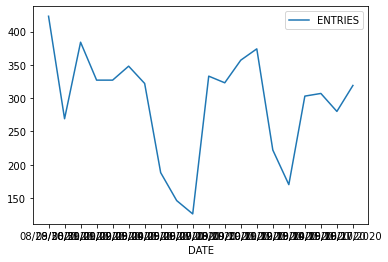

In [356]:
turnstile_list = turnstile_groups.index.droplevel(4).unique()
single_turnstile = turnstile_list[0]
single_turnstile_df = turnstile_groups.loc[single_turnstile]
# should i convert back into a singly-indexed DF and make date back into a column rather than index?
single_turnstile_df = sns.lineplot(data=single_turnstile_df)#, x=single_turnstile_df.index, y="ENTRIES") don't even need this

In [332]:
area_groups = turnstile_groups.groupby(["C/A", "UNIT", "STATION", "DATE"]).sum()
station_groups = turnstile_groups.groupby(["STATION", "DATE"]).sum()

In [333]:
station_list = station_groups.index.droplevel(1).unique()
single_station = station_list[0]
single_station_df = station_groups.loc[single_station]

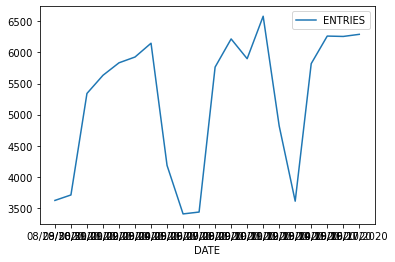

In [353]:
plot = sns.lineplot(data=station_groups.loc[single_station])

MultiIndex([(           '1 AV', '08/29/2020'),
            (           '1 AV', '08/30/2020'),
            (           '1 AV', '08/31/2020'),
            (           '1 AV', '09/01/2020'),
            (           '1 AV', '09/02/2020'),
            (           '1 AV', '09/03/2020'),
            (           '1 AV', '09/04/2020'),
            (           '1 AV', '09/05/2020'),
            (           '1 AV', '09/06/2020'),
            (           '1 AV', '09/07/2020'),
            ...
            ('WORLD TRADE CTR', '09/05/2020'),
            ('WORLD TRADE CTR', '09/06/2020'),
            ('WORLD TRADE CTR', '09/07/2020'),
            ('WORLD TRADE CTR', '09/08/2020'),
            ('WORLD TRADE CTR', '09/09/2020'),
            ('WORLD TRADE CTR', '09/10/2020'),
            ('WORLD TRADE CTR', '09/11/2020'),
            ('WORLD TRADE CTR', '09/12/2020'),
            ('WORLD TRADE CTR', '09/13/2020'),
            ('WORLD TRADE CTR', '09/14/2020')],
           names=['STATION', 'DATE'], lengt

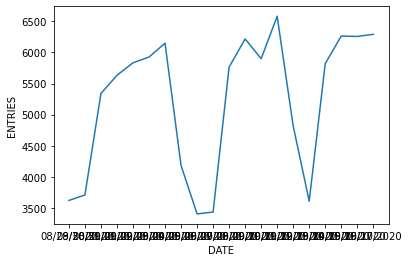

In [370]:
single_station_plot = sns.lineplot(data=single_station_df, x=single_station_df.index, y="ENTRIES")
station_groups.index

In [373]:
#g = sns.FacetGrid(data=station_groups, row=station_groups.[1], col="ENTRIES", margin_titles=True)

In [ ]:
station_by_week = station_groups.groupby(["STATION", lambda x: pd.to_datetime(x[1]).weekday() if pd.to_datetime(x[1]).weekday() != 0 else 7]).sum()
for i in range(15):
    single_station = station_list[i]
    single_station_by_week = station_by_week.loc[single_station]
    plot = sns.lineplot(data=single_station_by_week).set_title(single_station)
    
  
# try a facet grid with the station name as hue??